# Yelp Review Rating Prediction Using Text
### Tatiana Romanchishina

In [1]:
### libraries
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *
import itertools
import random
import scipy
import six
import re

from __future__ import print_function
from pprint import pprint
import time as time
import seaborn as sns
sns.set()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


#### Connect to Amazon S3 storage and download the file

In [2]:
import boto
import boto.s3.connection
from boto.s3.connection import S3Connection
conn = S3Connection()
bucket = conn.get_bucket('yelp-rest-reviews')
for key in bucket.list():
        print ("{name}\t{size}\t{modified}".format(
                name = key.name,
                size = key.size,
                modified = key.last_modified,
                ))

reviews_all.csv	663830339	2016-05-03T17:35:07.000Z


In [3]:
key = bucket.get_key('reviews_all.csv')
key.get_contents_to_filename('/home/ubuntu/yelp/reviews_all.csv')

### Load the data into a dataframe

In [2]:
path = r'/home/ubuntu/yelp/reviews_all.csv'
reviews = pd.read_csv(path)
reviews['Rating_nom'] = ["one" if Rating == 1 else "two" if Rating == 2 else "three" if Rating == 3 
                else "four" if Rating == 4 else "five" for Rating in reviews.Rating]
reviews = reviews[['Text','Rating_nom']]
reviews.head()

,Text,Rating_nom
0,I was underwhelmed I ordered the filet and i...,two
1,Fun environment friendly staff and decent foo...,four
2,Benjamin s is good bar restaurant on the Nort...,five
3,This place is awesome The food is great and t...,five
4,We loved Eddie and his very appeasing accent ...,five


In [3]:
reviews.shape

(990627, 2)

#### Load the necessary Machine Learning libraries

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC 
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import metrics
from sklearn.cross_validation import train_test_split

#### Helper function for plotting confusion matrix

In [5]:
labels = ["one","two","three","four","five"]

def plot_confusion(confmat):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confmat)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

             precision    recall  f1-score   support

        one       0.55      0.67      0.60     43983
        two       0.40      0.38      0.39     48605
      three       0.45      0.41      0.43     76837
       four       0.55      0.50      0.52    159890
       five       0.66      0.73      0.69    165999

avg / total       0.56      0.56      0.56    495314

             precision    recall  f1-score   support

        one       0.54      0.67      0.60     43230
        two       0.41      0.37      0.39     48971
      three       0.45      0.41      0.43     76785
       four       0.55      0.50      0.52    159648
       five       0.66      0.73      0.69    166679

avg / total       0.56      0.56      0.56    495313

Total reviews classified: 990627
Confusion matrix:
[[  58494.   19832.    4646.    2144.    2097.]
 [  24650.   36517.   26255.    7029.    3125.]
 [  11393.   21220.   62528.   46613.   11868.]
 [   7119.    8764.   37277.  158738.  107640.]
 [   5522

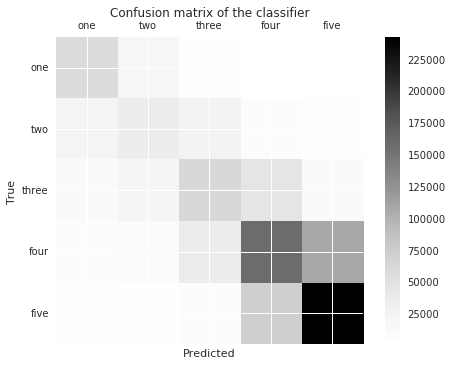

In [ ]:
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english',
                                   max_df=0.7, min_df=100)),
    #('transformer', TfidfTransformer()),
    ('classifier',  MultinomialNB()) ])

k_fold = KFold(n=len(reviews), n_folds=2)
scores = []
confusion = np.zeros(shape=(5,5))
for train_indices, test_indices in k_fold:
    train_text = reviews.iloc[train_indices]['Text'].values
    train_y = reviews.iloc[train_indices]['Rating_nom'].values

    test_text = reviews.iloc[test_indices]['Text'].values
    test_y = reviews.iloc[test_indices]['Rating_nom'].values

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    confusion += confusion_matrix(test_y, predictions, 
                                  labels = labels)
    print(metrics.classification_report(test_y, predictions, labels = labels))
print('Total reviews classified:', len(reviews))
#print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)
plot_confusion(confusion)

In [ ]:
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1,3), stop_words='english',
                                   max_df=0.7, min_df=100)),
    #('transformer', TfidfTransformer()),
    ('classifier',  SVC(kernel='linear')) ])

k_fold = KFold(n=len(reviews), n_folds=2)
scores = []
confusion = np.zeros(shape=(5,5))
for train_indices, test_indices in k_fold:
    train_text = reviews.iloc[train_indices]['Text'].values
    train_y = reviews.iloc[train_indices]['Rating_nom'].values

    test_text = reviews.iloc[test_indices]['Text'].values
    test_y = reviews.iloc[test_indices]['Rating_nom'].values

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    confusion += confusion_matrix(test_y, predictions, 
                                  labels = labels)
    print(metrics.classification_report(test_y, predictions, labels = labels))

print('Total reviews classified:', len(reviews))
#print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)
plot_confusion(confusion)

## Parameter Tuning

### Multinomial Naive Bayes

In [ ]:
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english')),
  #  ('transformer', TfidfTransformer()),
    ('nbClassifier',  MultinomialNB()) ])

parameters = {
    'vectorizer__ngram_range': ((1,1),(1,2)),
    'vectorizer__max_df': (0.6, 0.75, 1.0),
    'vectorizer__min_df': (100, 0.1, 0.3),
 #   'transformer__use_idf': (True, False),
    #'transformer__norm': ('l1', 'l2'),
    #'nbClassifier__fir_prior': (True, False) 
   # 'nbClassifier__alpha': (0.0, 0.5, 1.0)
}
        
if __name__ == "__main__":
    grid_search_nb = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=10)

    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time.time()
    grid_search_nb.fit(reviews.Text.values, reviews.Rating_nom.values)
    print("done in %0.3fs" % (time.time() - t0))
    print("Best score: %0.3f" % grid_search_nb.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search_nb.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

pipeline: ['vectorizer', 'transformer', 'nbClassifier']
parameters:
{'transformer__use_idf': (True, False),
 'vectorizer__max_df': (0.6, 0.75, 1.0),
 'vectorizer__min_df': (100, 0.1, 0.3),
 'vectorizer__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 3 folds for each of 54 candidates, totalling 162 fits


### Multinomial Logistic Regression

In [ ]:
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english')),
    ('transformer', TfidfTransformer()),
    ('lrClassifier',  LogisticRegression(multi_class='multinomial',solver='lbfgs')) ])

parameters = {
    'vectorizer__ngram_range': ((1,1),(1,2),(1,3)),
    'vectorizer__max_df': (0.5,0.75,1.0),
    'vectorizer__min_df': (1, 10, 0.01, 0.1),
    'transformer__use_idf': (True, False),
    #'transformer__norm': ('l1', 'l2'),
    'lrClassifier__max_iter': (50, 100, 200) 
    'lrClassifier__C': (0.1, 1.0, 10.0)
}
        
if __name__ == "__main__":
    grid_search1 = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=10)

    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time.time()
    grid_search1.fit(reviews.Text.values, reviews.Rating_nom.values)
    print("done in %0.3fs" % (time.time() - t0))
    print("Best score: %0.3f" % grid_search1.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search1.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

### Support Vector Machines

In [ ]:
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english')),
    ('transformer', TfidfTransformer()),
    ('svmClassifier',  SVC()) ])
parameters = {
    'vectorizer__ngram_range': ((1,1),(1,2),(1,3)),
    'vectorizer__max_df': (0.5,0.75,1.0),
    'vectorizer__min_df': (1, 10, 0.01, 0.1),
    'transformer__use_idf': (True, False),
    #'transformer__norm': ('l1', 'l2'),
    'svmClassifier__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
    #'svmClassifier__C': (0.1, 1.0, 10.0)
}
        
if __name__ == "__main__":
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=10)

    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time.time()
    grid_search.fit(reviews.Text.values, reviews.Rating_nom.values)
    print("done in %0.3fs" % (time.time() - t0))
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

pipeline: ['vectorizer', 'transformer', 'svmClassifier']
parameters:
{'svmClassifier__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
 'transformer__use_idf': (True, False),
 'vectorizer__max_df': (0.5, 0.75, 1.0),
 'vectorizer__min_df': (1, 10, 0.01, 0.1),
 'vectorizer__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [ ]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
print("Best score: %0.3f" % grid_search1.best_score_)
print("Best parameters set:")
best_parameters = grid_search1.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
print("Best score: %0.3f" % grid_search2.best_score_)
print("Best parameters set:")
best_parameters = grid_search2.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))